<a href="https://colab.research.google.com/github/Tclack88/MountainProject/blob/master/HangboardProgress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!ls

MorganHB1.xlsx	sample_data  TrevorHB1.xlsx


In [0]:
import pandas as pd
df = pd.read_excel('MorganHB1.xlsx')
df = pd.read_excel('TrevorHB1.xlsx')

In [0]:
df

,date,jug,imr,med_edge,pinch_med,mr_2fp,large_edge,pinch_wide,sloper,mrp_3fp
0,26 Oct 2019,0|6|0|60,-20|6|0|60,-45|6|0|60,-60|6|0|60,-50|6|0|60,-45|6|0|60,-55|6|0|60,-35|6|0|60,-45|6|0|60
1,2019-10-29 00:00:00,0|6|0|60,-17.5|5|1|57,-42.5|6|0|60,-57.5|6|0|60,-47.5|6|0|60,-42.5|6|0|60,-52.5|6|0|60,-32.5|6|0|60,-42.5|6|0|60
2,2019-11-01 00:00:00,0|6|0|60,-27.5|6|0|60,-40|6|0|60,-55|6|0|60,-45|6|0|60,-35|6|0|60,-50|6|0|60,-30|4|2|56,-40|5|1|54
3,2019-11-04 00:00:00,0|6|0|60,-25|6|0|60,-40|6|0|60,-55|6|0|60,-45|6|0|60,-35|6|0|60,-50|6|0|60,-30|6|0|60,-40|6|0|60
4,2019-11-07 00:00:00,0|6|0|60,-25|6|0|60,-37.5|6|0|60,-55|6|0|60,-42.5|6|0|60,-32.5|6|0|60,-47.5|6|0|60,-27.5|5|1|58,-37.5|5|1|59.5
5,2019-11-10 00:00:00,0|6|0|60,-22.5|6|0|60,-35|6|0|60,-52.5|6|0|60,-40|6|0|60,-30|6|0|60,-45|3|3|44,-25|4|2|53,-35|5|1|53
6,2019-11-13 00:00:00,0|6|0|60,-20|6|0|60,-32.5|6|0|60,-50|3|3|48,-37.5|6|0|60,-27.5|5|1|59,-42.5|3|0|52,-22.5|3|3|51,-32.5|4|2|55


In [0]:
df.date = pd.to_datetime(df.date)

In [0]:
df = df.set_index('date')
df

,jug,imr,med_edge,pinch_med,mr_2fp,large_edge,pinch_wide,sloper,mrp_3fp
date,,,,,,,,,
2019-10-26,0|6|0|60,-20|6|0|60,-45|6|0|60,-60|6|0|60,-50|6|0|60,-45|6|0|60,-55|6|0|60,-35|6|0|60,-45|6|0|60
2019-10-29,0|6|0|60,-17.5|5|1|57,-42.5|6|0|60,-57.5|6|0|60,-47.5|6|0|60,-42.5|6|0|60,-52.5|6|0|60,-32.5|6|0|60,-42.5|6|0|60
2019-11-01,0|6|0|60,-27.5|6|0|60,-40|6|0|60,-55|6|0|60,-45|6|0|60,-35|6|0|60,-50|6|0|60,-30|4|2|56,-40|5|1|54
2019-11-04,0|6|0|60,-25|6|0|60,-40|6|0|60,-55|6|0|60,-45|6|0|60,-35|6|0|60,-50|6|0|60,-30|6|0|60,-40|6|0|60
2019-11-07,0|6|0|60,-25|6|0|60,-37.5|6|0|60,-55|6|0|60,-42.5|6|0|60,-32.5|6|0|60,-47.5|6|0|60,-27.5|5|1|58,-37.5|5|1|59.5
2019-11-10,0|6|0|60,-22.5|6|0|60,-35|6|0|60,-52.5|6|0|60,-40|6|0|60,-30|6|0|60,-45|3|3|44,-25|4|2|53,-35|5|1|53
2019-11-13,0|6|0|60,-20|6|0|60,-32.5|6|0|60,-50|3|3|48,-37.5|6|0|60,-27.5|5|1|59,-42.5|3|0|52,-22.5|3|3|51,-32.5|4|2|55


In [0]:
cols = list(df.columns)
cols

['jug',
 'imr',
 'med_edge',
 'pinch_med',
 'mr_2fp',
 'large_edge',
 'pinch_wide',
 'sloper',
 'mrp_3fp']

In [0]:
hangs = []
for col in cols:
  print('\n\n',col)
  column = df[col]
  inner_df = column.str.split('|', expand=True) # looks like an error happens if I don't first do this, pardon the redundancy
  inner_df[['weight','success','fail','TUT']] = column.str.split('|', expand=True)
  inner_df = inner_df[['weight','success','fail','TUT']]
  inner_df = inner_df.apply(pd.to_numeric) # change to numeric columns
  inner_df.TUT = inner_df.TUT/60 # change TUT (Time under tension to a fraction of 60 seconds later for coloring)
  print(inner_df)
  hangs.append(inner_df[['weight','TUT']])



 jug
            weight  success  fail  TUT
date                                  
2019-10-26       0        6     0  1.0
2019-10-29       0        6     0  1.0
2019-11-01       0        6     0  1.0
2019-11-04       0        6     0  1.0
2019-11-07       0        6     0  1.0
2019-11-10       0        6     0  1.0
2019-11-13       0        6     0  1.0


 imr
            weight  success  fail   TUT
date                                   
2019-10-26   -20.0        6     0  1.00
2019-10-29   -17.5        5     1  0.95
2019-11-01   -27.5        6     0  1.00
2019-11-04   -25.0        6     0  1.00
2019-11-07   -25.0        6     0  1.00
2019-11-10   -22.5        6     0  1.00
2019-11-13   -20.0        6     0  1.00


 med_edge
            weight  success  fail  TUT
date                                  
2019-10-26   -45.0        6     0  1.0
2019-10-29   -42.5        6     0  1.0
2019-11-01   -40.0        6     0  1.0
2019-11-04   -40.0        6     0  1.0
2019-11-07   -37.5        6  

In [0]:
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [0]:
fig = go.Figure()

ending_weights = []

for hang in hangs:
  ending_weight = hang.weight[-1]
  ending_weights.append(ending_weight)
  fig.add_trace(go.Scatter(x=hang.index, y=hang.weight, mode='lines+markers'))

# Adding labels
annotations = []
for ending_weight, col in zip(ending_weights, cols):
    # labeling the right_side of the plot
    annotations.append(dict(xref='paper', x=1, y=ending_weight,
                                  xanchor='left', yanchor='middle',
                                  text=f'{col}',
                                  font=dict(family='Arial',
                                            size=16),
                                  showarrow=False))
    
# Title
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Hangboard Progress',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))

fig.update_layout(annotations=annotations,
                  showlegend=False) # alternatively can show legend (default to True) and remove label on right

fig.show()

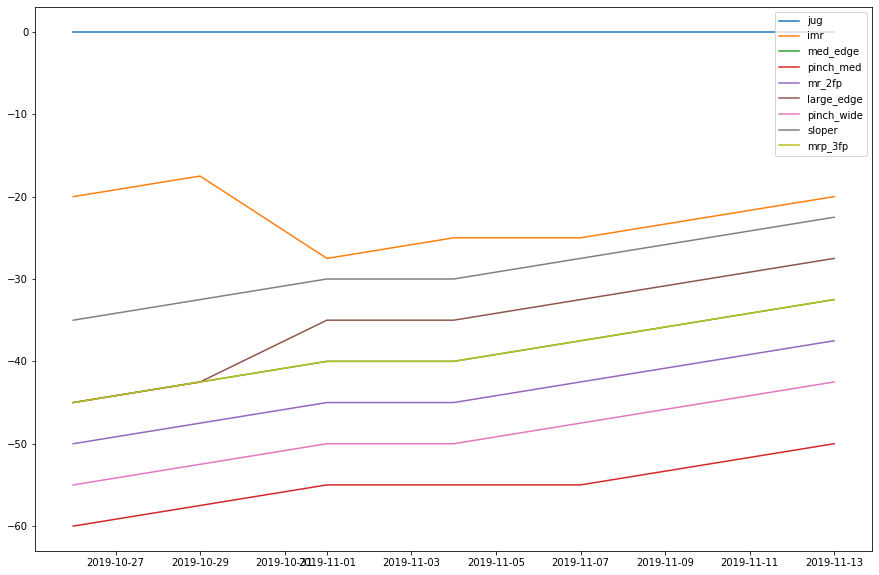

In [0]:
plt.figure(figsize=(15,10))
for hang in hangs:
  plt.plot(hang.index, hang.weight)

plt.legend(cols)
plt.show();